#  K-means Clustering

In [5]:
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
# set matplotlib to display all plots inline with the notebook
%matplotlib inline

## Help functions to load data and visualize images


In [6]:
def parse(x):
    """
    parse the digits file into tuples of 
    (digit label, numpy array of vector representation of digit image)
    """
    digit = loads(x)
    array = np.frombuffer(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

def display_digit(digit, training_or_inferred = "training"):
    """ 
    graphically display a 784x1 vector, representing a digit, and show the corresponding label
    
    """
 
    image = digit[1]
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if training_or_inferred == "training":
        title_str = "GT label: "
    else:
        title_str = "Inferred label: "
    plt.title(title_str  + str(digit[0]))
    
def display_vector(vector):
    """ 
    graphically display a 784x1 vector, representing a digit, without showing the label
    
    """
 
    plt.figure()
    fig = plt.imshow(vector.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
       

## 1 Dataset
### Load and Visualize dataset

The data file 'mnist.json' contains gray-scale images of handwritten digits, from 0 to 9. 

Each image is of size 784 with integers in the range $[0, 255]$, and the images can be reshaped to $28 \times 28$. The value of the pixels indicate the brightness of a pixel, that is, the higher number the brighter the pixel.

The dataset is split into training (first 1000), validation (following 400) and test datasets (last 600).

In [7]:
# prepare dataset
## load .json file
with open("mnist.json","r") as f:
    digits = list(map(parse, f.readlines()))
    
## split into train, validation and test datasets
train_data = digits[:1000]
val_data = digits[1000:1400]
test_data = digits[1400:2000]

### Data Structure 

* Each dataset is a list, in which each element is a tuple. 
* Each tuple contains the image's label and the image's pixel values. It is a pair of (label,vector), where "label" is a single digit and "vector" is an integer vector of shape (784,).

This is visualized below

In [8]:
print ('The type of training dataset is: ',type(train_data))
print ('The number of training samples is: ',len(train_data))
print ('The type of each data sample is: ',type(train_data[0]))
print ('The label of the first sample image is: ',train_data[0][0])
print ('The shape of the first sample image is: ',train_data[0][1].shape)

The type of training dataset is:  <class 'list'>
The number of training samples is:  1000
The type of each data sample is:  <class 'tuple'>
The label of the first sample image is:  5
The shape of the first sample image is:  (784,)


### Image Visualization

We can use the help function 'display_digit' to display the image of each data sample.

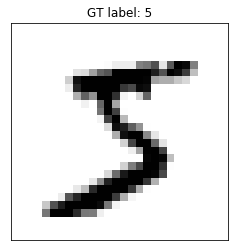

In [9]:
# display the first training sample
# for each digit, the first element is the label, the second one is the pixel value of the image.
display_digit(train_data[0], "training")

# 2 K-means Clustering Algorithm

First, we define some basic functions which will be used later. 

The following function initializes K cluster centers randomly from the inputed dataset.

In [10]:
# initialize k cluster centers randomly
def init_centers(labelled_data, K):
    """
    Randomly pick K values from the data as starting values for centers.
    Ignore their labels.
    
    input: training/validation/test dataset, K (number of clusters)
    output: a list containing initial centers, which are K different images without their labels.
    
    """

    center_list = []
    sampled_center = random.sample(labelled_data, K)
    for center_i in sampled_center:
        center_list.append(center_i[1])
    
    return center_list

The function for forming clusters, `build_clusters` assigns every datapoint in the dataset to a cluster, based on its distance to the cluster centers. The datapoint is assigned to the nearest cluster center.

In [12]:
# assign each datapont in the input dataset to the nearest center based on current centers
def build_clusters(labelled_data, unlabelled_centers):
    """
    given datapoints and current centers, assign each datapoint
    to its nearest center. This builds clusters.
    
    Note that we do not need the label information when assign the digit, therefore, it is unsupervised
    
    input: labelled_data: the list of data tuples, each tuple contains (label,vector)
           unlabelled_centers: current centers before this step
    output: list of digits(tuples) that assigned to different centers 
    """
    # enumerate because centers are arrays which are unhashable
    # (basically we assign each center a number (i.e. cluster center #x)
    # but this is not related to the digit the cluster is supposed to represent)
    centers_indices = range(len(unlabelled_centers))
    
    # initialize an empty dict for each center. The dict will contain
    # all the datapoints that are closer to that center than to any other.
    # That list is the cluster of that center.
    clusters = {c: [] for c in centers_indices}
    
    for (label,vector) in labelled_data:
        # for each datapoint, pick the closest center.
        smallest_distance = float("inf")
        for cj_index in centers_indices:
            cj = unlabelled_centers[cj_index]
            
            distance = np.sqrt(((vector - cj)**2).sum())
            if distance < smallest_distance:
                closest_center_index = cj_index
                smallest_distance = distance
        
        # allocate that datapoint to the cluster of that center.
        clusters[closest_center_index].append((label,vector))
    return list(clusters.values())

Let's check the results after building clusters based on train dataset and initial centers.

In [13]:
# test code for building clusters
clusters = build_clusters(train_data, original_centers)
# the number of clusters should be the same as the number of centers, which is 10 here
print ('the number of clusters are: ',len(clusters))
for i,cluster in enumerate(clusters):
    print ('the number of data tuples assigned to the %d cluster is %d'%(i+1,len(cluster)))

the number of clusters are:  10
the number of data tuples assigned to the 1 cluster is 84
the number of data tuples assigned to the 2 cluster is 86
the number of data tuples assigned to the 3 cluster is 65
the number of data tuples assigned to the 4 cluster is 106
the number of data tuples assigned to the 5 cluster is 140
the number of data tuples assigned to the 6 cluster is 46
the number of data tuples assigned to the 7 cluster is 176
the number of data tuples assigned to the 8 cluster is 111
the number of data tuples assigned to the 9 cluster is 130
the number of data tuples assigned to the 10 cluster is 56


Below, we take a look at what the clusters look like.

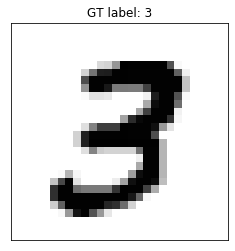

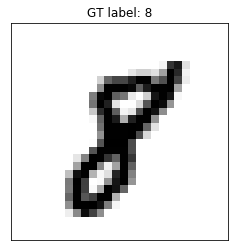

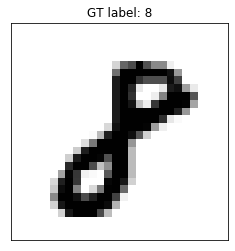

In [14]:
# test code for building clusters
# display digits that assigned to the same cluster, 
# here, take the first 3 datapoints from the first cluster as example.
for data_tuple in clusters[0][:3]:
    display_digit(data_tuple, "training")

The function `mean_cluster()` finds the cluster center of a given cluster, to be used for updating centers.

In [15]:
# compute the center of a cluster
def mean_cluster(labelled_cluster):
    """
    compute the mean (i.e. the center at the middle) of a list of vectors (a cluster).
    take the sum and then divide by the size of the cluster.
    assume all datapoints in labelled_cluster are labelled.
    
    input: labelled_center: one cluster 
    output: the mean of this cluster through all datapoints in this cluster
    """  
    # element-wise sums a list of arrays. The initial value is the first date vector
    sum_of_points = labelled_cluster[0][1].copy()
    
    for (label,vector) in labelled_cluster[1:]: 
        sum_of_points += vector
    
    # mean w.r.t the size of the cluster
    mean_of_points = sum_of_points * (1.0 / len(labelled_cluster))
    return mean_of_points

The updating is in turn done by the function `move_centers()`, using `mean_cluster()`.

In [16]:
# update centers
def move_centers(labelled_clusters):
    """
    return a list of centers corresponding to the current clusters by computing their means.
    
    input: labelled_centers: a list of current clusters 
    output: new_centers: a list of new centers 
    """
    new_centers = []
    # compute the mean of each cluster
    for cluster in labelled_clusters:
        new_centers.append(mean_cluster(cluster))
    return new_centers

What do the centers look like after one iteration?

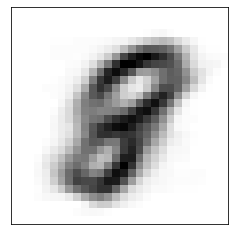

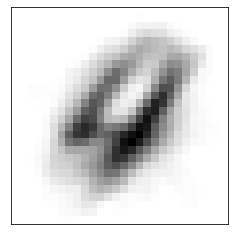

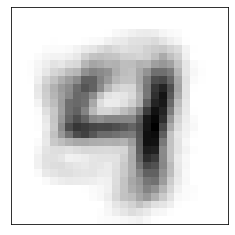

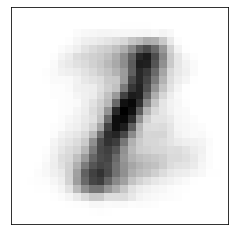

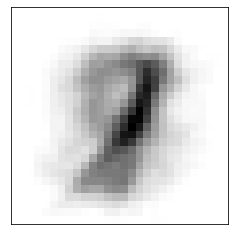

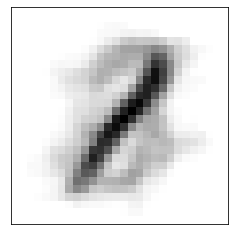

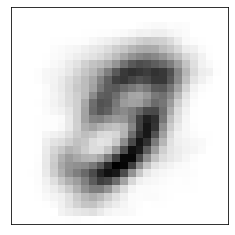

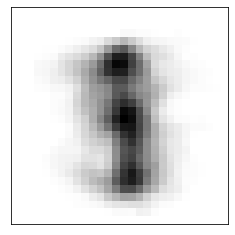

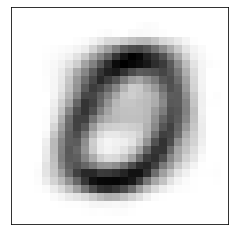

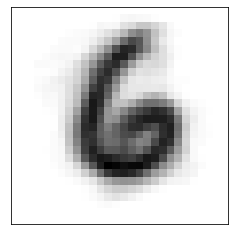

In [17]:
# test code for the first movement of centers
new_centers = move_centers(clusters)
# display new centers
for center in new_centers:
    display_vector(center)

Now, this procedure of finding centers and building new clusters will be performed iteratively, calling `repeat_until_convergence()`.

In [18]:
def repeat_until_convergence(labelled_data, unlabelled_centers, labelled_clusters):
    """
    build clusters around centers, then keep moving the centers
    until the moves are no longer significant, i.e. we've found
    the best-fitting centers for the data.
    
    input: labelled_data: training datasets 
           unlabelled_centers: initial centers
           labelled_clusters: initial clusters based on inital centers
    output: 
           labelled_clusters: clusters from the last update
           unlabelled_centers: centers from the last update
    """
    
    previous_max_difference = 0
    while True:
        unlabelled_old_centers = unlabelled_centers
        unlabelled_centers = move_centers(labelled_clusters)
        labelled_clusters = build_clusters(labelled_data, unlabelled_centers)
        # we keep old_clusters and clusters so we can get the maximum difference
        # between center positions every time. We say the centers have converged
        # when the maximum difference between center positions is small.   
        differences=[]
        for old_center, new_center in zip(unlabelled_old_centers,unlabelled_centers):
            difference = np.sqrt(((old_center - new_center)**2).sum())
            differences.append(difference)
            
        max_difference = max(differences)
        difference_change = abs((max_difference-previous_max_difference)/np.mean([previous_max_difference,max_difference])) * 100
        previous_max_difference = max_difference
        # difference change is nan once the list of differences is all zeroes.
        if np.isnan(difference_change):
            break
    return labelled_clusters, unlabelled_centers

Now, let's tie everything togehter with the `cluster()` function.

In [19]:
# main function for k-means clustering 
def cluster(labelled_data, k):
    """
    run k-means clustering on the data. It is assumed that the data is labelled.
    
    input: labelled_data: datapoints will be clustered.
           k: the number of clusters
    output: lists of final clusters and centers
    """
    # step 1: initialize centers randomly and set up clusters
    centers = init_centers(labelled_data, k)
    clusters = build_clusters(labelled_data, centers)
    # step 2: update centers util convergence
    final_clusters, final_centers = repeat_until_convergence(labelled_data, centers, clusters)
    return list(final_clusters), list(final_centers)

### Help functions after clustering.

Run the cells below.

In [20]:
# After clustering
def assign_labels_to_centers(clusters, centers):
    """
    Assign a digit label to each cluster.
    Cluster is a list of clusters containing labelled datapoints.
    NOTE: this function depends on clusters and centers being in the same order.
    """
    labelled_centers = []
    for i in range(len(clusters)):
        labels = []
        for data_tuple in clusters[i]:
            labels.append(data_tuple[0])
        # pick the most common label
        most_common = max(set(labels), key=labels.count)
        center = (most_common, centers[i])
        labelled_centers.append(center)
    return labelled_centers

# used for validating and testing
def classify_digit(digit, labelled_centers):
    """
    given an unlabelled digit represented by a vector and a list of
    labelled centers [(label,vector)], determine the closest center
    and thus classify the digit.
    """
    mindistance = float("inf")
    for (label, center) in labelled_centers:
        distance = np.sqrt(((center - digit)**2).sum())
        if distance < mindistance:
            mindistance = distance
            closest_center_label = label
    return closest_center_label

# compute error rate after geting final centers
def get_error_rate(digits, labelled_centers):
    """
    classifies a list of labelled test digits. returns the error rate.
    """
    classified_incorrect = 0
    for (label,vector) in digits:
        classified_label = classify_digit(vector, labelled_centers)
        if classified_label != label:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(digits))
    return error_rate

Let's run and test!

In [21]:
k = 10
trained_clusters, trained_centers = cluster(train_data, k)
labelled_centers = assign_labels_to_centers(trained_clusters, trained_centers)
error_rate = get_error_rate(val_data, labelled_centers)
print(f'Error rate of {k} clusters is {error_rate}')

Error rate of 10 clusters is 0.4325


C:\Users\tsigk\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


#### Visualization of the centers togehter with their inferred labels.

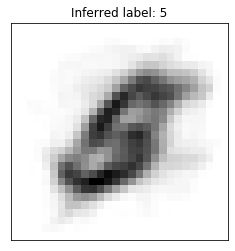

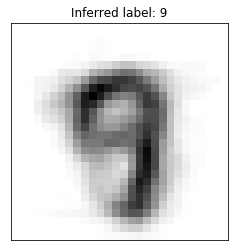

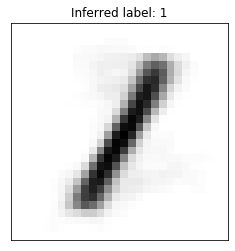

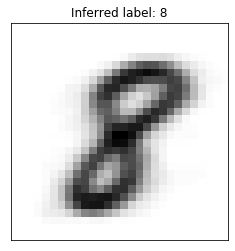

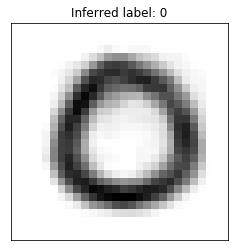

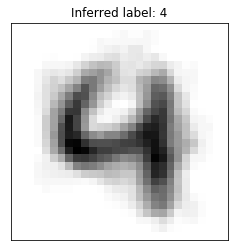

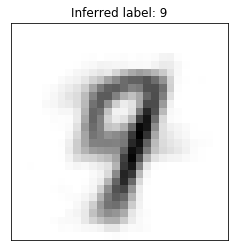

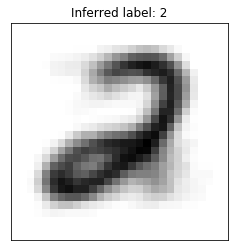

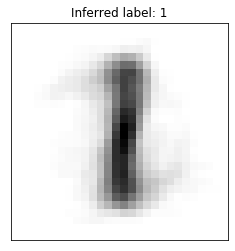

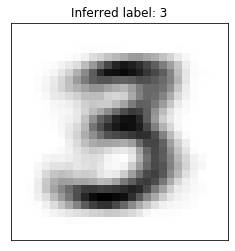

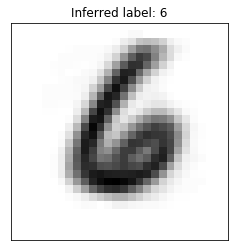

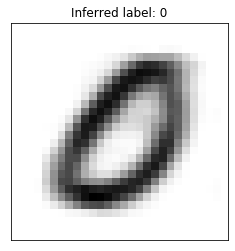

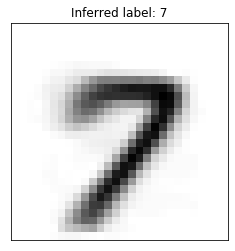

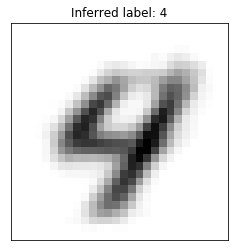

In [24]:
for x in labelled_centers:
    display_digit(x, "inferred")

### Examining k, the number of clusters

Let us check the error rate regarding the number of clusters, from 5 to 15.

C:\Users\tsigk\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


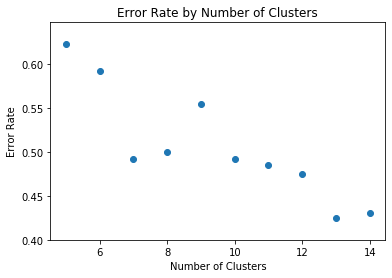

In [23]:
error_rates = {x:None for x in range(5,15)}
for k in range(5,15):
    trained_clusters, trained_centers = cluster(train_data, k)
    labelled_centers = assign_labels_to_centers(trained_clusters, trained_centers)
    error_rate = get_error_rate(val_data, labelled_centers)
    error_rates[k] = error_rate

# Show the error rates
x_axis = sorted(error_rates.keys())
y_axis = [error_rates[key] for key in x_axis]
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()